In [634]:
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier


In [620]:
# Import each training sample, put into matrix so X_tr is (114,1500)
num_sampertype_tr = 5
num_types_tr = 3
num_samples_tr = num_sampertype_tr*num_types_tr
num_feats_tr = 114
num_timesteps_tr = 100
#X_tr = np.zeros((num_samples, num_feats*num_timesteps))
X_tr = np.zeros((num_feats_tr, num_samples_tr*num_timesteps_tr))

types = ['jumping','running','walking']
s = 0
for type in types:
    for i in range(1,num_sampertype_tr+1):
        sample_path = f'/Users/jadeg/Documents/UW/winter/AMATH 582/HW2/hw2data/train/{type}_{i}.npy'
        sample = np.load(sample_path)
        X_tr[:, s * num_timesteps_tr : (s + 1) * num_timesteps_tr] = sample  # Stack in time direction
        s += 1


In [621]:
# Import each test sample, put into matrix so X_te is (114,300)
num_sampertype_te = 1
num_types_te = num_types_tr
num_samples_te = num_sampertype_te*num_types_te
num_feats_te = num_feats_tr
num_timesteps_te = num_timesteps_tr
X_te = np.zeros((num_feats_te, num_samples_te*num_timesteps_te))

types = ['jumping','running','walking']
s = 0
for type in types:
    for i in range(1,num_sampertype_te+1):
        sample_path = f'/Users/jadeg/Documents/UW/winter/AMATH 582/HW2/hw2data/test/{type}_1t.npy'
        sample = np.load(sample_path)
        X_te[:, s * num_timesteps_te : (s + 1) * num_timesteps_te] = sample  # Stack in time direction
        s += 1


In [622]:
# Apply PCA with full number of spatial nodes to the training data
pca = PCA()
X_pca = pca.fit_transform(X_tr.T) #reduce dimensions


In [623]:
# Apply PCA fit to test data
X_pca_te = pca.transform(X_te.T) #reduce dimensions
 

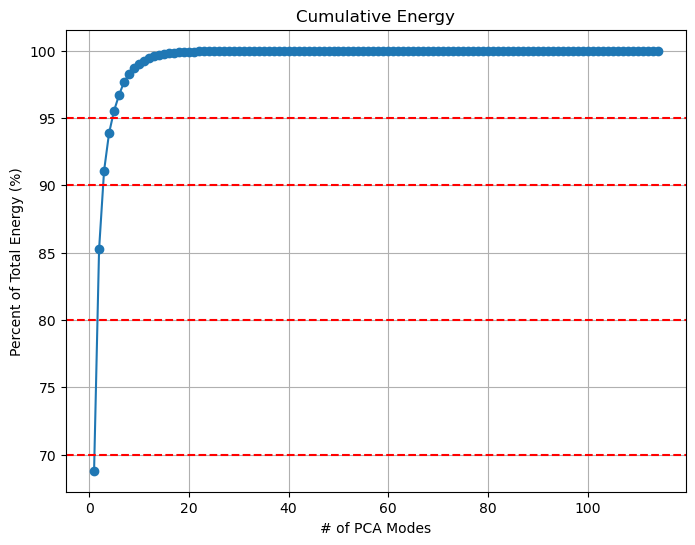

In [624]:
# Task 1, 

# pull out singular values to calculate norm
S = pca.singular_values_
norm_full = np.sqrt(np.sum(S**2))

# apply PCA with approximation (low rank SVD)
x = np.arange(1,num_feats_tr+1)
y = np.zeros(num_feats_tr)
j = 0
for n_nodes in x:
    S_n = S[0:n_nodes]
    norm_approx = np.sqrt(np.sum(S_n**2)) 
    y[j] = (norm_approx/norm_full) * 100
    j+= 1

# plot cumulative energy
plt.figure(figsize=(8,6))

plt.plot(x,y,'o-')
plt.grid()

# add lines are percents in problem statement
percs = [70,80,90,95]
for perc in percs:
    plt.axhline(y=perc, color='r', linestyle='--')

plt.xlabel('# of PCA Modes')

plt.ylabel('Percent of Total Energy (%)')
plt.title('Cumulative Energy')
#plt.xlim([0,15])
#plt.savefig('/Users/jadeg/Documents/UW/winter/AMATH 582/HW2/ZoomedCumEnergy.png')
plt.savefig('/Users/jadeg/Documents/UW/winter/AMATH 582/HW2/CumEnergy.png')

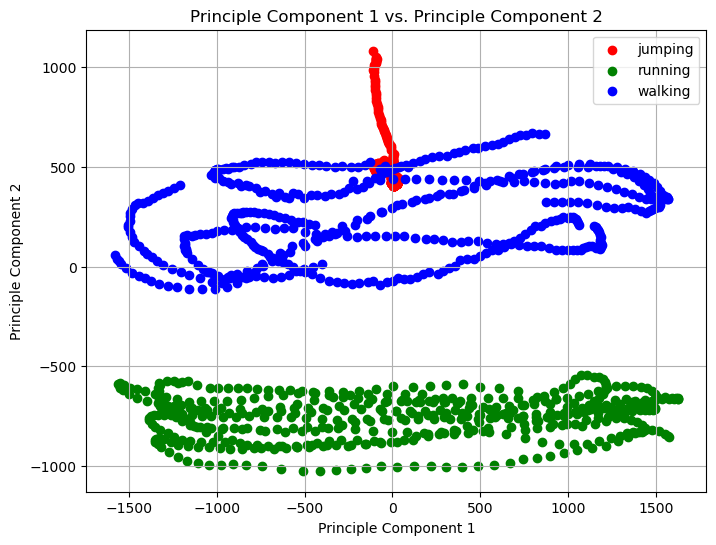

In [625]:
# Task 2a: truncate to 2 modes and plot

# pull out PC1 and PC2
PC1 = X_pca[:,0]
PC2 = X_pca[:,1]

# plot cumulative energy
plt.figure(figsize=(8,6))
plt.grid()

colors = ['r', 'g', 'b']
labels = ['jumping', 'running', 'walking']

for i, activity in enumerate(labels):
    start_idx = i * num_sampertype_tr * num_timesteps_tr   # Each activity has 5 samples, each with 100 timesteps
    end_idx = (i+1) * num_sampertype_tr * num_timesteps_tr
    plt.scatter(PC1[start_idx:end_idx], PC2[start_idx:end_idx], 
                c=colors[i], label=activity)

plt.legend()
plt.xlabel('Principle Component 1')
plt.ylabel('Principle Component 2')
plt.title('Principle Component 1 vs. Principle Component 2')
plt.savefig('/Users/jadeg/Documents/UW/winter/AMATH 582/HW2/2D_PC.png')

Plotting jumping: start_idx=0, end_idx=500
Plotting running: start_idx=500, end_idx=1000
Plotting walking: start_idx=1000, end_idx=1500


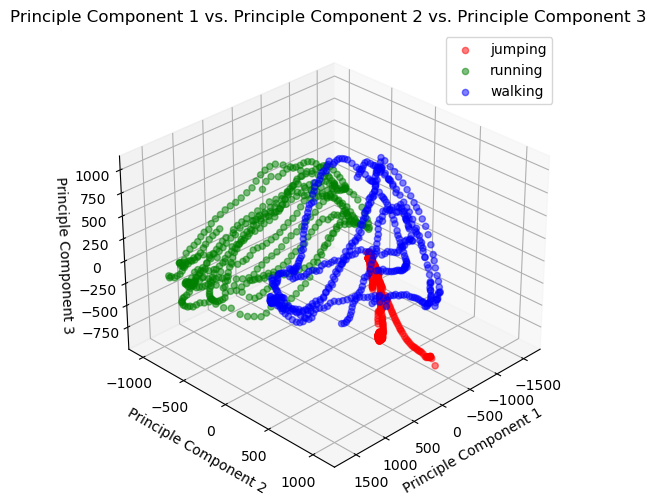

In [626]:
# Task 2b: truncate to 3 modes and plot

# pull out PC3
PC3 = X_pca[:,2]

# plot cumulative energy
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(projection='3d')


colors = ['r', 'g', 'b']
labels = ['jumping', 'running', 'walking']

for i, activity in enumerate(labels):
    start_idx = i * num_sampertype_tr * num_timesteps_tr   # Each activity has 5 samples, each with 100 timesteps
    end_idx = (i+1) * num_sampertype_tr * num_timesteps_tr
    print(f"Plotting {activity}: start_idx={start_idx}, end_idx={end_idx}")  # Debug print
    ax.scatter(PC1[start_idx:end_idx], PC2[start_idx:end_idx], PC3[start_idx:end_idx],
               c=colors[i], label=activity, alpha=0.5)

plt.legend()
ax.set_xlabel('Principle Component 1')
ax.set_ylabel('Principle Component 2')
ax.set_zlabel('Principle Component 3')
ax.view_init(elev=30, azim=45)
plt.title('Principle Component 1 vs. Principle Component 2 vs. Principle Component 3')
plt.savefig('/Users/jadeg/Documents/UW/winter/AMATH 582/HW2/3D_PC.png')

In [627]:
# create empty array to store accuracy scores
k_range = np.array([])
scores_tr = np.array([])
scores_te = np.array([])

# Task 3 - create vector of ground truth labels and assign a label to each sample and compute mean
for k in range(1,num_feats_tr+1):
    k_range = np.append(k_range,k)
    # make new array of just vectors 1 to k
    X_pca_k_tr = X_pca[:,:k]
    X_pca_rek_tr = X_pca_k_tr.reshape(num_samples_tr, num_timesteps_tr, k)  # Shape: (15, 100, k)

    # create vector of ground truth labels
    ground_truth_labs_tr = np.array([0]*num_sampertype_tr + [1]*num_sampertype_tr + [2]*num_sampertype_tr)

    # Make an empty dictionary for centroids
    centroids = {}

    # for each movement, assign them to the centroid dictionary
    for movement in [0, 1, 2]:
        movement_samples = X_pca_rek_tr[ground_truth_labs_tr == movement]  # Get samples of this movement
        centroid = np.mean(movement_samples, axis=(0, 1))  # Average over time and samples
        centroids[movement] = centroid

    '''for movement, centroid in centroids.items():
        print(f"Centroid {movement}, {labels[movement]}: {centroid}")'''

    # Task 4 - create another vector of trained labels
    trained_labs = np.zeros(num_samples_tr)

    # measure the distance between each value and the centroids
    # take the norm of each vector minus the centroid
    for i in range(0,num_samples_tr):
        j_dist = np.linalg.norm((X_pca_rek_tr[i,:,:]) - centroids[0])
        r_dist = np.linalg.norm((X_pca_rek_tr[i,:,:]) - centroids[1])
        w_dist = np.linalg.norm((X_pca_rek_tr[i,:,:]) - centroids[2])
        dist = np.array([j_dist,r_dist,w_dist])
        if j_dist == np.min(dist):
            trained_labs[i] = 0
        if r_dist == np.min(dist):
            trained_labs[i] = 1
        if w_dist == np.min(dist):
            trained_labs[i] = 2
    #print(trained_labs)

    accuracy_tr = accuracy_score(ground_truth_labs_tr, trained_labs)
    scores_tr = np.append(scores_tr,accuracy_tr)


    # LOOK AT TESTING DATA NOW -------------------------------------------------
    # do PCA reduction to k spatial nodes
    X_pca_k_te = X_pca_te[:,:k]
    X_pca_rek_te = X_pca_k_te.reshape(num_samples_te, num_timesteps_te, k)  # Shape: (3, 100, k)

    # create vector of ground truth labels, jumping:0, running:1, walking:2
    ground_truth_labs_te = np.array([0]*num_sampertype_te + [1]*num_sampertype_te + [2]*num_sampertype_te)

    # Task 4 - create another vector of trained labels
    test_labs = np.zeros(num_samples_te)

    # measure the distance between each value and the centroids
    # take the norm of each vector minus the centroid
    for i in range(0,num_samples_te):
        j_dist = np.linalg.norm((X_pca_rek_te[i,:,:]) - centroids[0])
        r_dist = np.linalg.norm((X_pca_rek_te[i,:,:]) - centroids[1])
        w_dist = np.linalg.norm((X_pca_rek_te[i,:,:]) - centroids[2])
        dist = np.array([j_dist,r_dist,w_dist])
        #print(dist)
        if j_dist == np.min(dist):
            test_labs[i] = 0
        if r_dist == np.min(dist):
            test_labs[i] = 1
        if w_dist == np.min(dist):
            test_labs[i] = 2

    accuracy_te = accuracy_score(ground_truth_labs_te, test_labs)
    #print(test_labs)
    scores_te = np.append(scores_te,accuracy_te)




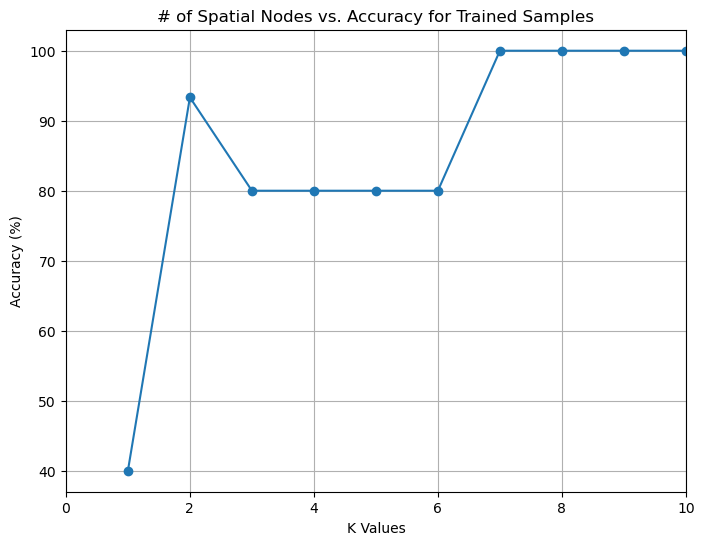

In [628]:
# accuracies for optimal k
plt.figure(figsize=(8,6))

plt.plot(k_range,scores_tr*100,'o-')
plt.xlabel('K Values')
plt.ylabel('Accuracy (%)')

plt.title('# of Spatial Nodes vs. Accuracy for Trained Samples')
plt.grid()
plt.savefig('/Users/jadeg/Documents/UW/winter/AMATH 582/HW2/train_accuracy_full.png')

plt.xlim([0,10])
plt.savefig('/Users/jadeg/Documents/UW/winter/AMATH 582/HW2/train_accuracy_zoom.png')

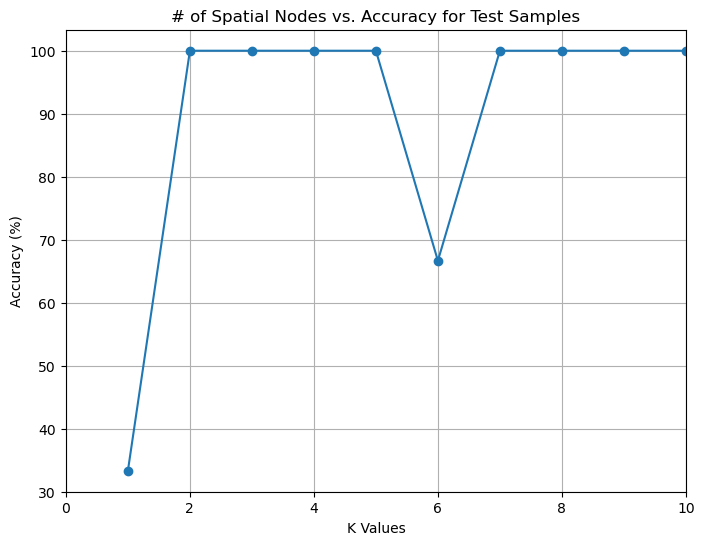

In [630]:
# graph accuracy
# accuracies for optimal k
plt.figure(figsize=(8,6))

plt.plot(k_range,scores_te*100,'o-')
plt.xlabel('K Values')
plt.ylabel('Accuracy (%)')
plt.title('# of Spatial Nodes vs. Accuracy for Test Samples')
plt.grid()
plt.savefig('/Users/jadeg/Documents/UW/winter/AMATH 582/HW2/test_accuracy_full.png')

plt.xlim([0,10])
plt.savefig('/Users/jadeg/Documents/UW/winter/AMATH 582/HW2/test_accuracy_zoom.png')

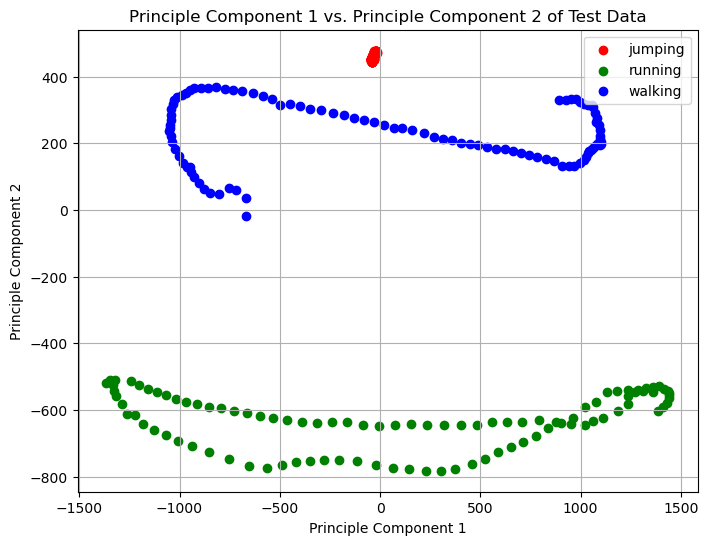

<Figure size 640x480 with 0 Axes>

In [632]:
# test data plot in 2D

# pull out PC1 and PC2
PC1_te = X_pca_te[:,0]
PC2_te = X_pca_te[:,1]

# plot cumulative energy
plt.figure(figsize=(8,6))
plt.grid()

colors = ['r', 'g', 'b']
labels = ['jumping', 'running', 'walking']

for i, activity in enumerate(labels):
    start_idx = i * num_sampertype_te * num_timesteps_te   # Each activity has 5 samples, each with 100 timesteps
    end_idx = (i+1) * num_sampertype_te * num_timesteps_te
    plt.scatter(PC1_te[start_idx:end_idx], PC2_te[start_idx:end_idx], 
                c=colors[i], label=activity)

plt.legend()
plt.xlabel('Principle Component 1')
plt.ylabel('Principle Component 2')
plt.title('Principle Component 1 vs. Principle Component 2 of Test Data')
plt.show()
plt.savefig('/Users/jadeg/Documents/UW/winter/AMATH 582/HW2/test_2DPC.png')


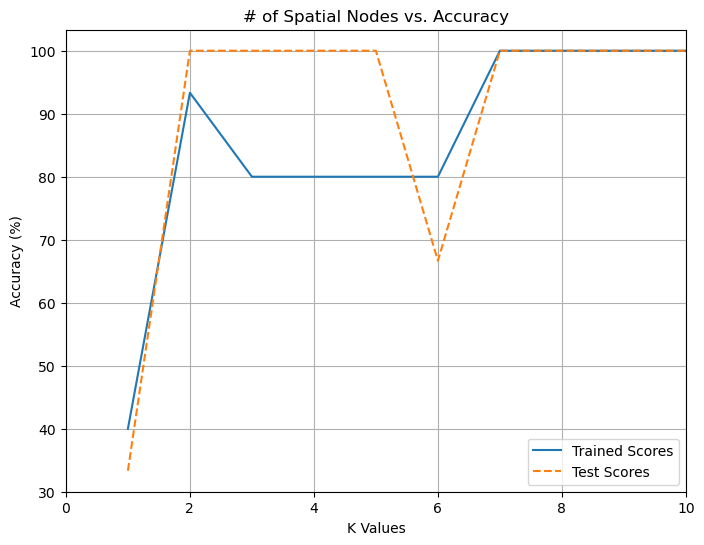

In [633]:
# graph both on same graph
plt.figure(figsize=(8,6))

plt.plot(k_range,scores_tr*100,'-')
plt.plot(k_range,scores_te*100,'--')
labels = ['Trained Scores', 'Test Scores']
plt.legend(labels)
plt.xlabel('K Values')
plt.ylabel('Accuracy (%)')

plt.title('# of Spatial Nodes vs. Accuracy')
plt.grid()
plt.savefig('/Users/jadeg/Documents/UW/winter/AMATH 582/HW2/both_accuracy_full.png')

plt.xlim([0,10])
plt.savefig('/Users/jadeg/Documents/UW/winter/AMATH 582/HW2/both_accuracy_zoom.png')

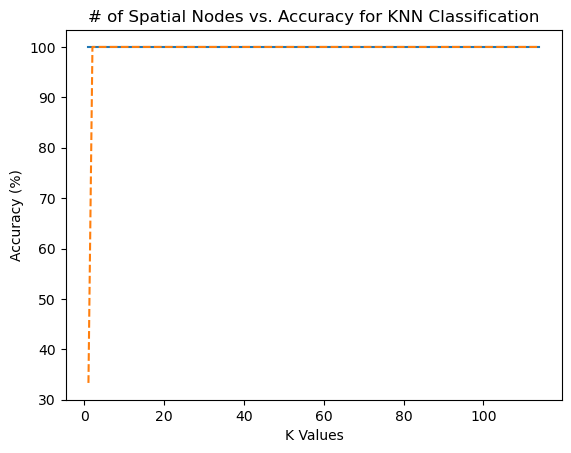

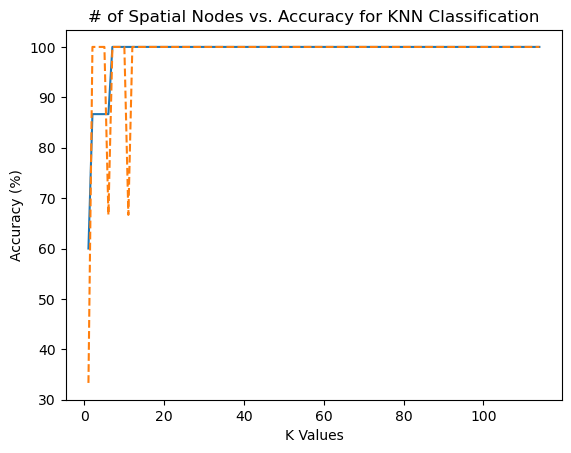

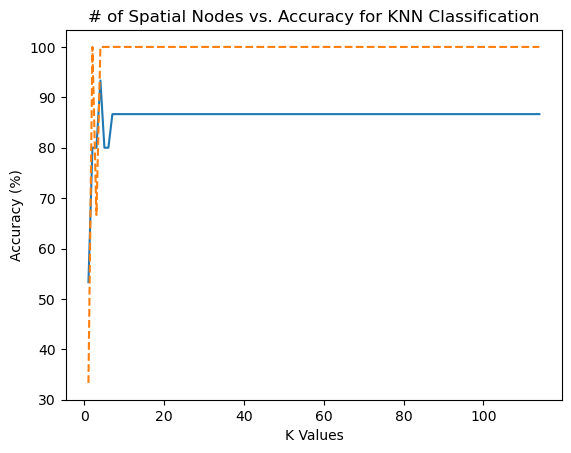

In [647]:
# Extra Credit - KNN Classification


k_neigh_array = [1,3,5]
for k_neighbors in k_neigh_array:
    KNNscores_tr = np.array([])
    KNNscores_te = np.array([])

    for k in range(1,num_feats_tr+1):
        #Perform PCA on Training Data
        pca_KNN = PCA(n_components=k)
        X_pca_tr_KNN = pca_KNN.fit_transform(X_tr.T)  # Fit PCA to training data
        X_pca_tr_reKNN = X_pca_tr_KNN.reshape(num_samples_tr, num_timesteps_tr, k).mean(axis=1)  # reshape to (15, k)

        #Do PCA on Test Data to project data onto k-PCA space
        X_pca_te_KNN = pca_KNN.transform(X_te.T)  # Project test data onto k-PCA space
        X_pca_te_reKNN = X_pca_te_KNN.reshape(num_samples_te, num_timesteps_tr, k).mean(axis=1)  # reshape to (3, k)

        # Train k-NN Classifier
        KNN = KNeighborsClassifier(n_neighbors=k_neighbors)
        KNN.fit(X_pca_tr_reKNN, ground_truth_labs_tr)  # Train the classifier

        # Predict for Train and Test Data
        pred_tr = KNN.predict(X_pca_tr_reKNN)
        pred_te = KNN.predict(X_pca_te_reKNN)

        # Get accuracy scores for Train and Test Data
        accuracy_KNN_tr = accuracy_score(ground_truth_labs_tr, pred_tr)
        accuracy_KNN_te = accuracy_score(ground_truth_labs_te, pred_te)

        # save to arrays
        KNNscores_tr = np.append(KNNscores_tr,accuracy_KNN_tr*100)
        KNNscores_te = np.append(KNNscores_te,accuracy_KNN_te*100)

    plt.figure()
    plt.plot(k_range,KNNscores_tr,'-')
    plt.plot(k_range,KNNscores_te,'--')
    plt.xlabel('K Values')
    plt.ylabel('Accuracy (%)')
    plt.title('# of Spatial Nodes vs. Accuracy for KNN Classification')
    plt.savefig(f'/Users/jadeg/Documents/UW/winter/AMATH 582/HW2/KNN_Class_{k_neighbors}.png')
